In [2]:
#Computação científica
import numpy as np

#análise de dados
import pandas as pd

#machine learning
from sklearn.linear_model import LogisticRegression #regressão lasso
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb


#mtricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve


#visualização
import matplotlib.pyplot as plt
import seaborn as sns

#sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

#pipeline
from imblearn.pipeline import Pipeline

#cross validation
from sklearn.model_selection import StratifiedKFold

#barra indicando porcentagem de conclusão
from tqdm import tqdm




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#Parâmetros

In [3]:
#Definir a seed para que os resultados obtidos sejam sempre os mesmos

seed=0

In [4]:
#Estilo dos gráficos do seaborn

sns.set_theme(style="darkgrid")


In [5]:
#se train_models=False os modelos não serão treinados. Eles já foram previamente treinados e os resultados serão carregados da memória
#se train_models=True os modelos serão treinados
train_models=True

# Carregar *Dados*

In [6]:
path='/content/drive/MyDrive/Rodolfo/porto/porto-seguro-safe-driver-prediction/'



Dataset com as features selecionadas através das correlações.

O processo de feature selection gerou uma pequena melhoria de performance no caso da regressão logística.O mesmo não ocorreu no caso do LightGBM. Como a melhoria no primeiro caso foi muito pequena, não será realizada nenhuma feature selection adicional (além da aplicada na com o uso das correlações) para simplificar o processo ao usando o mesmo dataset para treinar os modelos

In [7]:
#Dados com colunas selecionadas através do calculo da correlação para uso com LighGBM

x_train = pd.read_csv(path+'train_selected_features_transformed.csv')
x_val   = pd.read_csv(path+'val_selected_features_transformed.csv')

y_train = np.ravel(pd.read_csv(path+'y_train.csv'))
y_val   = np.ravel(pd.read_csv(path+'y_val.csv'))

print("Número de features: {}".format(np.shape(x_train)[1]))

Número de features: 108


# Funções para Treinamento dos modelos

In [18]:
#Função para treinar modelo com stratifiedkfold
def calcular_auc_stratifiedkfold(model_lr,model_lgb,x,y,n_splits=10,amostragem=None):
  """
  Função para treinar regressão logśitica e lightgbm com o uso de stratifiedkfold e retornar uma lista com
  o roc_auc score de cada um dos modelos

  Inputs:
    model_lr    - instância de um objeto do modelo regressão logistica.
    model_lgb   - instância de um objeto do modelo lightgbm.
    x        - (pandas dataframe) dados de entrada do modelo
    y        - (np array) output esperado do moldelo
    n_splits - (int) número de splits usadas na validação cruzada
    amostragem - determinar se os dados serão amostrados para o treinamento do modelo. Se amostragem = None
                 não será aplicada nenhuma amostragem. PAra aplicar ume método de amostragem a variável amostragem
                 deve recebem um objeto com método fit_resample

  Outputs
    auc_lr     - (list) lista com o auc score da regressão logística obtido com os dados separados para teste na validação cruzada
    auc_lgb     - (list)lista com o auc score do LightGBM obtido com os dados separados para teste na validação cruzada

   """

  #criação de objeto stratifiedkfold
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
  auc_lr  = []
  auc_lgb = []
  progress_bar = tqdm(total=n_splits)
  for train_index, test_index in skf.split(x, y):
      x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      if amostragem is not None:
        x_train_fold, y_train_fold=amostragem.fit_resample(x_train_fold, y_train_fold)
      model_lr.fit(x_train_fold, y_train_fold)
      model_lgb.fit(x_train_fold, y_train_fold)
      auc_lr.append(roc_auc_score(y_test_fold,model_lr.predict_proba(x_test_fold)[:,1]))
      auc_lgb.append(roc_auc_score(y_test_fold,model_lgb.predict_proba(x_test_fold)[:,1]))
      progress_bar.update(1)
  return auc_lr,auc_lgb

# Técnicas de Amostragem

## Random Undersamplig + Smote

In [10]:
#razão entre o número de amostras da classe minoritária e da classe majoritária

np.sum(y_train==1)/np.sum(y_train==0)

0.03782674325340879

Undersampling da classe majoritária para aumentar a razão o número de amostras da classe minoritária e da classe majoritária

In [11]:
#random undersampling
razao=0.1 #razão entre o número de amostras da classe minoritária e da classe majoritária
ru=RandomUnderSampler(sampling_strategy=razao,random_state=seed)


Oversampling da classe minoritária para igualar o número de amostras das duas classes.


In [12]:
smote=SMOTE(random_state=seed)

Agrupar as duas transformações em uma pipeline

In [13]:
pipe_rus=Pipeline([('random undersampling',ru),
                   ('Smote',smote)])

## Smote + Tomek Links

Oversampling da classe minoritária com Smote e undersampling da classe majoritária com Tomek links.

In [14]:
smt=SMOTETomek(random_state=seed)

#Treinamento dos modelos

Treinamento dos modelos com o dataset original e com duas técnicas de amostragem. São elas:

1.   Random Undersampling + Smote
2.   Smote + Tomek Links



In [15]:
#regressão logistica
best_parameters_lr = np.load(path+'/best_parameters_lr.npy',allow_pickle='TRUE').item()
logistic_model     = LogisticRegression(random_state=seed,solver='saga',max_iter=1000,**best_parameters_lr)


In [16]:
#LightGBM
best_parameters_lgb = np.load(path+'/best_parameters_lgb.npy',allow_pickle='TRUE').item()
lgb_model = lgb.LGBMClassifier(importance_type='gain',**best_parameters_lgb)


In [19]:
if train_models:
  resultado_baseline_lr,resultado_baseline_lgb = calcular_auc_stratifiedkfold(logistic_model,lgb_model,x_train,y_train)
  resultado_rus_lr ,resultado_rus_lgb     = calcular_auc_stratifiedkfold(logistic_model,lgb_model,x_train,y_train,amostragem=pipe_rus)
  resultado_smt_lr ,resultado_smt_lgb     = calcular_auc_stratifiedkfold(logistic_model,lgb_model,x_train,y_train,amostragem=smt)

  resultado_lr=pd.DataFrame({ 'baseline': resultado_baseline_lr,
                              'random undersampling + smote': resultado_rus_lr,
                              'smote + tomek links': resultado_smt_lr})

  resultado_lgb=pd.DataFrame({'baseline': resultado_baseline_lgb,
                              'random undersampling + smote': resultado_rus_lgb,
                              'smote + tomek links': resultado_smt_lgb})


  resultado_lr.to_csv(path +'resultado_lr.csv',index=False)
  resultado_lgb.to_csv(path+'resultado_lgb.csv',index=False)


else:
  resultado_lr =pd.read_csv(path+'resultado_lr.csv')
  resultado_lgb=pd.read_csv(path+'resultado_lgb.csv')

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 10%|█         | 1/10 [02:32<22:49, 152.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 20%|██        | 2/10 [05:01<20:02, 150.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 30%|███       | 3/10 [07:31<17:32, 150.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 40%|████      | 4/10 [10:00<14:58, 149.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 50%|█████     | 5/10 [12:27<12:24, 148.92s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 60%|██████    | 6/10 [14:55<09:53, 148.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 70%|███████   | 7/10 [17:23<07:24, 148.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 80%|████████  | 8/10 [19:49<04:55, 147.71s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 90%|█████████ | 9/10 [22:17<02:27, 147.65s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136670, number of negative: 136670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 273340, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 10%|█         | 1/10 [01:28<13:19, 88.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136670, number of negative: 136670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 273340, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 20%|██        | 2/10 [02:55<11:42, 87.85s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136670, number of negative: 136670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 273340, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 30%|███       | 3/10 [04:24<10:17, 88.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136670, number of negative: 136670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 273340, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 40%|████      | 4/10 [05:53<08:50, 88.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136670, number of negative: 136670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24511
[LightGBM] [Info] Number of data points in the train set: 273340, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 50%|█████     | 5/10 [07:23<07:24, 88.94s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136670, number of negative: 136670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 273340, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 60%|██████    | 6/10 [08:50<05:54, 88.53s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136680, number of negative: 136680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 273360, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 70%|███████   | 7/10 [10:18<04:25, 88.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136680, number of negative: 136680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24507
[LightGBM] [Info] Number of data points in the train set: 273360, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 80%|████████  | 8/10 [11:31<02:46, 83.25s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136680, number of negative: 136680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24509
[LightGBM] [Info] Number of data points in the train set: 273360, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 90%|█████████ | 9/10 [13:00<01:25, 85.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 136680, number of negative: 136680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 273360, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361312, number of negative: 361312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 722624, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 10%|█         | 1/10 [21:43<3:15:31, 1303.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361308, number of negative: 361308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24509
[LightGBM] [Info] Number of data points in the train set: 722616, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 20%|██        | 2/10 [44:21<2:58:03, 1335.41s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361313, number of negative: 361313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24511
[LightGBM] [Info] Number of data points in the train set: 722626, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 30%|███       | 3/10 [1:06:03<2:34:00, 1320.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361314, number of negative: 361314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24509
[LightGBM] [Info] Number of data points in the train set: 722628, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 40%|████      | 4/10 [1:27:42<2:11:11, 1311.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361309, number of negative: 361309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24510
[LightGBM] [Info] Number of data points in the train set: 722618, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 50%|█████     | 5/10 [1:49:18<1:48:51, 1306.25s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361312, number of negative: 361312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24509
[LightGBM] [Info] Number of data points in the train set: 722624, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 60%|██████    | 6/10 [2:10:55<1:26:51, 1303.00s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361313, number of negative: 361313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24509
[LightGBM] [Info] Number of data points in the train set: 722626, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 70%|███████   | 7/10 [2:32:37<1:05:07, 1302.61s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361312, number of negative: 361312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24507
[LightGBM] [Info] Number of data points in the train set: 722624, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 80%|████████  | 8/10 [2:54:09<43:18, 1299.44s/it]  

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361308, number of negative: 361308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24509
[LightGBM] [Info] Number of data points in the train set: 722616, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 90%|█████████ | 9/10 [3:15:43<21:37, 1297.58s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 361313, number of negative: 361313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24512
[LightGBM] [Info] Number of data points in the train set: 722626, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


100%|██████████| 10/10 [3:37:48<00:00, 1306.85s/it]


Text(0, 0.5, 'ROC AUC')

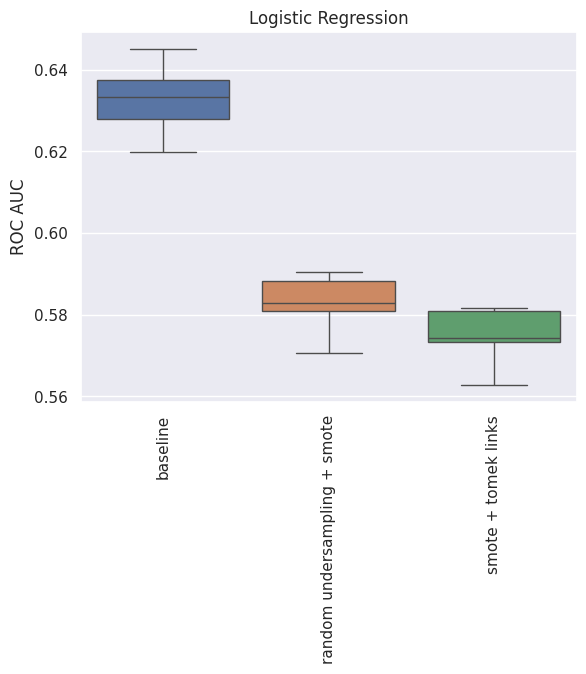

In [23]:
sns.boxplot(resultado_lr)
plt.title('Logistic Regression')
plt.xticks(rotation=90)
plt.ylabel('ROC AUC')

O uso de técnicas de amostragem não gerou melhoras no resultado.





Text(0, 0.5, 'ROC AUC')

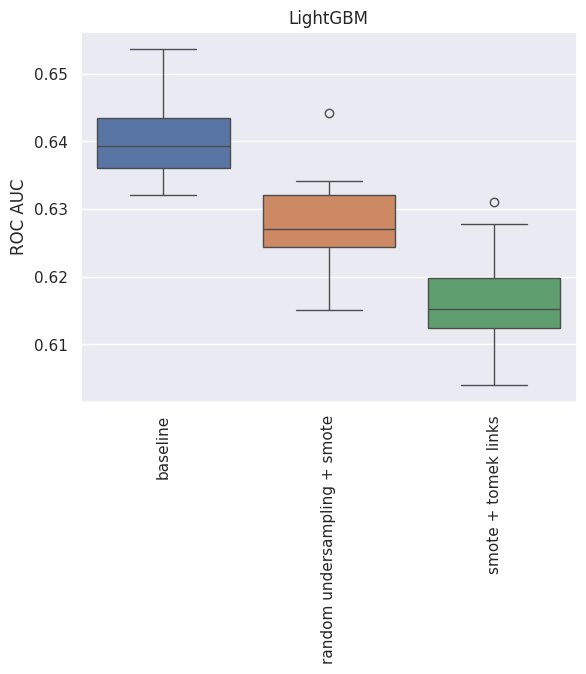

In [25]:
sns.boxplot(resultado_lgb)
plt.title('LightGBM')
plt.xticks(rotation=90)
plt.ylabel('ROC AUC')

A aplicação de técnicas de amostragem para balancear o número de amostras no dataset não melhorou os resultados obtidos.